In [4]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/Train'
valid_path = 'Datasets/Test'

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

  
  # useful for getting number of classes
folders = glob(r'C:\Users\KIRAN\Desktop\Machine Learning\facerecognition--cv2\Deep-Learning-Face-Recognition/Datasets/Train/*')
  



In [5]:
folders

['C:\\Users\\KIRAN\\Desktop\\Machine Learning\\facerecognition--cv2\\Deep-Learning-Face-Recognition/Datasets/Train\\phani',
 'C:\\Users\\KIRAN\\Desktop\\Machine Learning\\facerecognition--cv2\\Deep-Learning-Face-Recognition/Datasets/Train\\pk']

In [6]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(r'C:\Users\KIRAN\Desktop\Machine Learning\facerecognition--cv2\Deep-Learning-Face-Recognition\Datasets\Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(r'C:\Users\KIRAN\Desktop\Machine Learning\facerecognition--cv2\Deep-Learning-Face-Recognition\Datasets\Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''



Found 74 images belonging to 2 classes.
Found 65 images belonging to 2 classes.


'r=model.fit_generator(training_set,\n                         samples_per_epoch = 8000,\n                         nb_epoch = 5,\n                         validation_data = test_set,\n                         nb_val_samples = 2000)'

In [8]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=1,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)


Epoch 1/1
3/3 [==============================] - 88s 29s/step - loss: 1.0190 - accuracy: 0.5270 - val_loss: 8.5350e-05 - val_accuracy: 0.9692


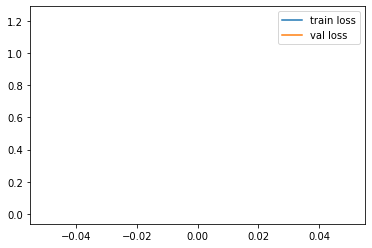

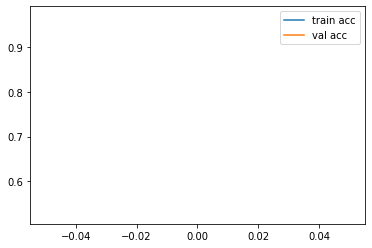

<Figure size 432x288 with 0 Axes>

In [9]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_accuracy')

import tensorflow as tf

from keras.models import load_model

model.save('facefeatures_new_models.h5')


In [14]:
# -*- coding: utf-8 -*-


# Face Recognition

# Importing the libraries
from PIL import Image
from keras.applications.vgg16 import preprocess_input
import base64
from io import BytesIO
import json
import random
import cv2
from keras.models import load_model
import numpy as np

from keras.preprocessing import image
model = load_model('facefeatures_new_models.h5')

# Loading the cascades
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def face_extractor(img):
    # Function detects faces and returns the cropped face
    # If no face detected, it returns the input image
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    
    if faces is ():
        return None
    
    # Crop all faces found
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
        cropped_face = img[y:y+h, x:x+w]

    return cropped_face

# Doing some Face Recognition with the webcam
video_capture = cv2.VideoCapture(0)
while True:
    _, frame = video_capture.read()
    #canvas = detect(gray, frame)
    #image, face =face_detector(frame)
    
    face=face_extractor(frame)
    if type(face) is np.ndarray:
        face = cv2.resize(face, (224, 224))
        im = Image.fromarray(face, 'RGB')
           #Resizing into 128x128 because we trained the model with this image size.
        img_array = np.array(im)
                    #Our keras model used a 4D tensor, (images x height x width x channel)
                    #So changing dimension 128x128x3 into 1x128x128x3 
        img_array = np.expand_dims(img_array, axis=0)
        pred = model.predict(img_array)
        print(pred)
                     
        name="None matching"
        
        if(pred[0][0]>0.5):
            name='Phani'
        cv2.putText(frame,name, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
    else:
        cv2.putText(frame,"No face found", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()

       



[[1. 0.]]
[[1.0000000e+00 2.0178554e-35]]
[[1. 0.]]
[[1.000000e+00 3.188335e-25]]
[[1.000000e+00 7.748613e-34]]
[[1.0000000e+00 5.7266207e-21]]
[[1.0000000e+00 2.3840333e-22]]
[[1.0000000e+00 1.4962842e-22]]
[[1.0000000e+00 1.4969754e-29]]
[[1.0000000e+00 1.3064216e-23]]
[[1.0000000e+00 1.3286223e-28]]
[[1.0000000e+00 9.4966774e-23]]
[[1.0000000e+00 7.8825243e-29]]
[[1.000000e+00 7.562765e-27]]
[[1.0000000e+00 2.2469811e-26]]
[[1.0000000e+00 9.6960225e-25]]
[[1.0000000e+00 1.4467021e-28]]
[[1.0000000e+00 6.0427988e-28]]
[[1.0000000e+00 1.5803871e-27]]
[[1.0000000e+00 1.6197883e-31]]
[[1.0000000e+00 3.7264977e-28]]
[[1.000000e+00 4.331208e-31]]
[[1.0000000e+00 1.4628497e-30]]
[[1.0000000e+00 1.3574419e-32]]
[[1.000000e+00 5.372409e-26]]
[[1.0000000e+00 2.6390777e-28]]
[[1.0000000e+00 4.5565985e-27]]
[[1.0000000e+00 1.0317174e-27]]
[[1.000000e+00 2.133383e-31]]
[[1.000000e+00 6.780321e-30]]
[[1.000000e+00 1.656571e-29]]
[[1.0000000e+00 1.7566028e-29]]
[[1.000000e+00 9.950076e-31]]
[[1.00

KeyboardInterrupt: 

In [7]:
from PIL import Image
import base64
from io import BytesIO
import json
import random
import cv2
import numpy as np